# Programming Assignment 1: MNIST

## PACKAGE IMPLEMENTATION

Download the necessary libraries

In [1]:
# Import the libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf # used for one hot encoding

## DATA LOADING AND DATA PREPARATION

Here the GPU can be used since it is computed with Torch.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# Get the training and testing datasets
# First need to transform the images into a suitable form (normalization)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])

# DataLoader class
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

dataloaders = {}
# First I import the "full" dataset without dividing it into batches. I'll do it during the training of the model
dataloaders['train'] = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(testset, len(testset), shuffle=True)

# train_features, train_labels = next(iter(dataloaders['train']))
test_features, test_labels = next(iter(dataloaders['test']))
test_features = test_features.to(device)
test_labels = test_labels.to(device)

Architecture: I/P → h1(500) → h2(250) → h3(100) → O/P
</br>
Here I reported basically the same Net. The flatten is done during the process. The data are not pre processed as in the manual case.

In [3]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten(1, -1)
        self.layer1 = nn.Linear(28*28, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the matrix
        x = self.flatten(x)
        # First layer
        out1 = self.relu(self.layer1(x))
        # Second layer
        out2 = self.relu(self.layer2(out1))
        # Third layer
        out3 = self.relu(self.layer3(out2))
        # Output layer: CrossEntropyLoss() already combines softmax and loss
        output = self.output_layer(out3)
        return output

Below the summary of the Net. We can see the total number of parameters for every layer.

In [5]:
model = Net().to(device)
print(model)

summary(model,input_size=(1,28*28))

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=250, bias=True)
  (layer3): Linear(in_features=250, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 250]         125,250
              ReLU-5                  [-1, 250]               0
            Linear-6                  [-1, 100]          25,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 543,860
Tr

In [22]:
def calculate_accuracy(Y_hat_onehot, Y):
    """
    Calculating accuracy of the parameter at the output.
    :param:
    Y: ground truth in one hot encoding.
    Y_hat: prediction of the NN in one hot encoding.

    :return:
    accuracy: finding the matches of the prdicted vs the actual
    """
    Y_hat = torch.argmax(Y_hat_onehot,axis=1) # actual value (digit from 0 to 9) shape (64,)
    test_acc = (Y_hat == Y).float().mean()
    return test_acc

Below the train model function is very similar to the train_model function of the manual case. Some parameters are different since the definition of the Net is pretty different now.

In [13]:
def train_model(model, dataloader, loss_fn, optimizer, num_epochs=15, device='cpu'):
    """
    Train the model given the data. For num_epochs of time the model is trained, which
    means that, based on the backward propagation, the weights (params) are adjusted.
    The loss function is also saved so to understand if the model is actually learning well.
    :param:
    model: desired network to be trained
    dataloader: torch loader of the training data (inputs and labels)
    loss_fn: loss function to use during the training of the network
    optimizer: optimizer to use during the training of the network
    num_epochs: for how many epochs the model will be trained?
    device: in this case just cpu is available since I'm working with numpy

    :return:
    batch_loss: list of loss every 200 iterations (i.e 200 batch updates)
    losses: list of loss function for every epoch (in total num_epochs values)
    parameters: weights of the net for every layer trained
    train_accuracy: accuracy of the model on the training data
    test_loss: list of loss function every 200 iterations on ALL the test data
    """
    model.train()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)
    train_loss = []
    test_loss = []
    batch_loss = []
    train_accuracy = []

# test_features, test_labels = next(iter(dataloaders['test']))
# X_test,y_test = test_data

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_batch = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_batch += 1

            if running_batch % 200 == 0:
              batch_loss.append(running_loss/running_batch)
              train_accuracy.append(calculate_accuracy(outputs, labels))

              # Loss for the test dataset
              outputs = model(test_features)
              test_cost = loss_fn(outputs, test_labels)
              test_loss.append((test_cost.item() * test_features.size(0))/len(test_labels))

        train_loss.append(running_loss/len(dataloader.dataset))
        # print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss[-1]:.4f}')

    return train_loss, test_loss, batch_loss, train_accuracy

I made some experiments on the net.

*   SGD learning rate 0.01 loss decreases smoothly - Accuracy on validation set: 96.57%
*   Adam learning rate 0.01 loss fluctuactes - Accuracy on validation set: 96.05%
*   Adam learning rate 0.001 loss decreases smoothly - Accuracy on validation set: 98.14%

With 0.001 LR it seems to minimize quite well the loss function. For the last epochs the gradient gets "stuck" and get fluctuating close to 0 but it seems the best result so far.
</br>
Moreover, I think the Adam optimizer with learning ratae 0.01 tends to fluctuate because Adam is a pretty unstable function and it is not usually use for simple net (as this one). Anyway with a lower LR the results are better.

In [14]:
# Initialize the model, criterion, and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
train_loss, test_loss, batch_loss, train_accuracy = train_model(model, dataloaders['train'], criterion, optimizer, num_epochs=15, device=device)

Epoch [1/15], Loss: 0.1319
Epoch [2/15], Loss: 0.0817
Epoch [3/15], Loss: 0.0594
Epoch [4/15], Loss: 0.0483
Epoch [5/15], Loss: 0.0394
Epoch [6/15], Loss: 0.0340
Epoch [7/15], Loss: 0.0288
Epoch [8/15], Loss: 0.0253
Epoch [9/15], Loss: 0.0248
Epoch [10/15], Loss: 0.0218
Epoch [11/15], Loss: 0.0209
Epoch [12/15], Loss: 0.0181
Epoch [13/15], Loss: 0.0154
Epoch [14/15], Loss: 0.0195
Epoch [15/15], Loss: 0.0138


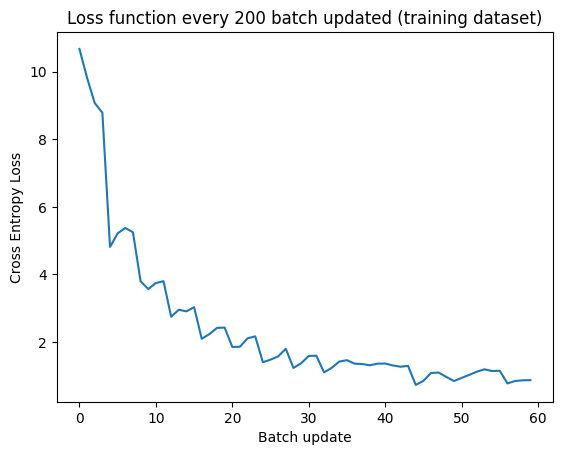

In [15]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(batch_loss)), batch_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (training dataset)')
plt.show()

Decreasing trend with some fluctuation due to the computation of every 200 iterations (and not at the end of the epoch).

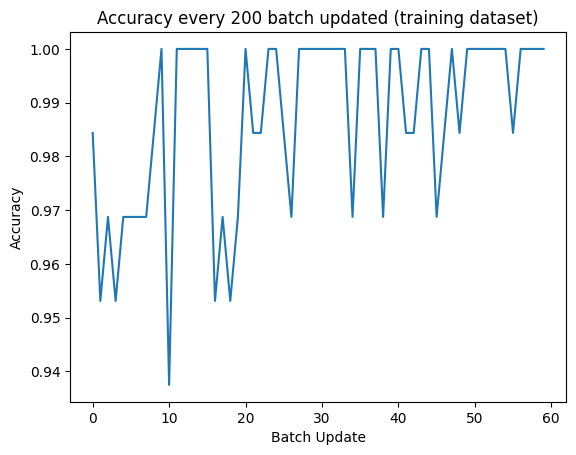

In [23]:
plt.plot(range(0, len(train_accuracy)), [acc.cpu().numpy() for acc in train_accuracy])
plt.xlabel('Batch Update')
plt.ylabel('Accuracy')
plt.title('Accuracy every 200 batch updated (training dataset)')
plt.show()

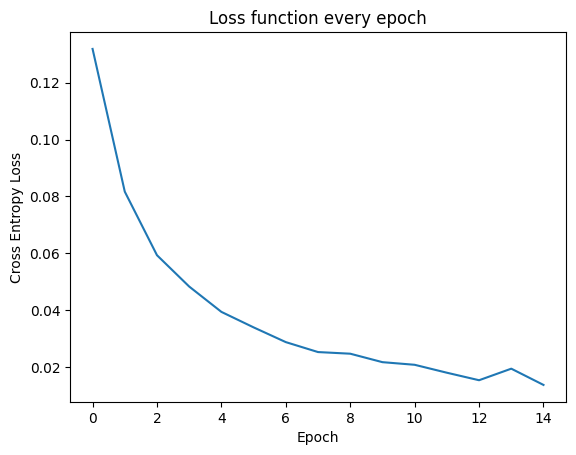

In [24]:
plt.plot(range(0,len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every epoch')
plt.show()

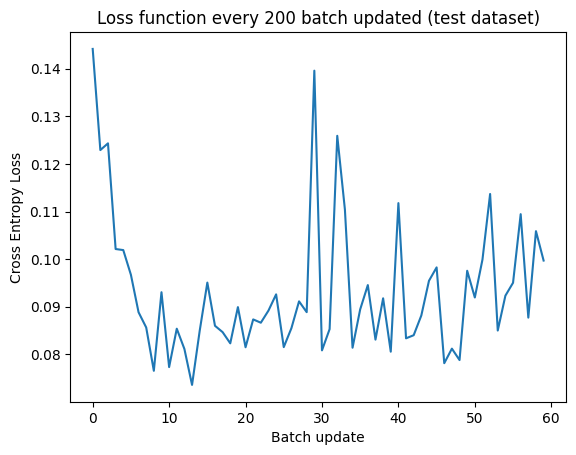

In [25]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(test_loss)), test_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (test dataset)')
plt.show()

Both the loss as respect to the test and training data are decreasing. Probably I expect an increase of the test loss function by increasing the number of epochs since the loss is not regularized (increase of variance).

In [33]:
# Fetch the test data (NB: batch for test loader is the length of test dataset, therefore I fetch all the data)
data_iter = iter(dataloaders['test'])
test_data = next(data_iter)

X_test,y_test = test_data

def evaluate_model(model, dataloader, device='cpu'):
    misclassified = 0
    total = len(dataloader.sampler)

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
      for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to("cpu") # need to put labels into cpu to make the computation
        test_labels_onehot_p = model(inputs.float())
        test_labels_p = np.argmax(test_labels_onehot_p.detach().cpu().numpy(), axis=1)
        misclassified += np.count_nonzero(labels-test_labels_p)

    accuracy = 1 - misclassified / total
    print('Accuracy on validation set: {:.2f}%'.format(100 * accuracy))

# Evaluate the model on the test data
evaluate_model(model, dataloaders['test'], device=device)

Accuracy on validation set: 98.06%


### 4.1 Regularization
By using the library it should be easy to apply the regularization. Just need to set the beta (regularization term).

In [34]:
# Initialize the model, criterion, and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# SGD learning rate 0.001 loss decreases smoothly Accuracy on validation set: 97.10%
# Adam learning rate 0.01 loss fluctuactes # Accuracy on validation set: 96.33%
# Adam learning rate 0.001 loss decreases smoothly # Accuracy on validation set: 97.83%

# Train the model
train_loss, test_loss, batch_loss, train_accuracy = train_model(model, dataloaders['train'], criterion, optimizer, num_epochs=15, device=device)

Epoch [1/15], Loss: 0.0089
Epoch [2/15], Loss: 0.0075
Epoch [3/15], Loss: 0.0068
Epoch [4/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0059
Epoch [6/15], Loss: 0.0056
Epoch [7/15], Loss: 0.0054
Epoch [8/15], Loss: 0.0052
Epoch [9/15], Loss: 0.0050
Epoch [10/15], Loss: 0.0048
Epoch [11/15], Loss: 0.0046
Epoch [12/15], Loss: 0.0045
Epoch [13/15], Loss: 0.0043
Epoch [14/15], Loss: 0.0042
Epoch [15/15], Loss: 0.0041


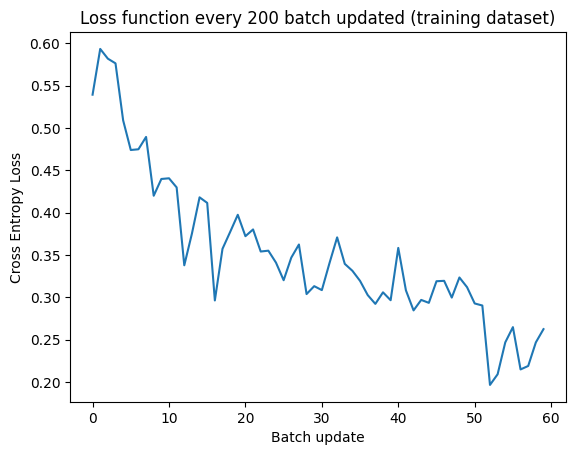

In [35]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(batch_loss)), batch_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (training dataset)')
plt.show()

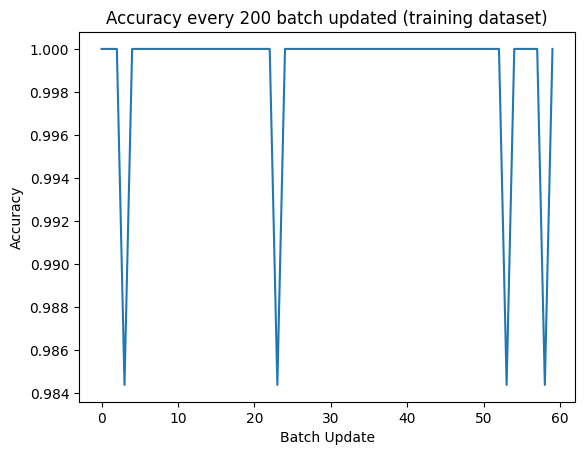

In [37]:
plt.plot(range(0, len(train_accuracy)), [acc.cpu().numpy() for acc in train_accuracy])
plt.xlabel('Batch Update')
plt.ylabel('Accuracy')
plt.title('Accuracy every 200 batch updated (training dataset)')
plt.show()

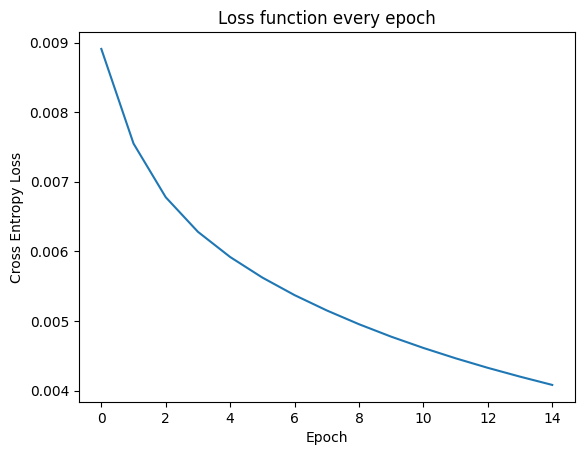

In [39]:
plt.plot(range(0,len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every epoch')
plt.show()

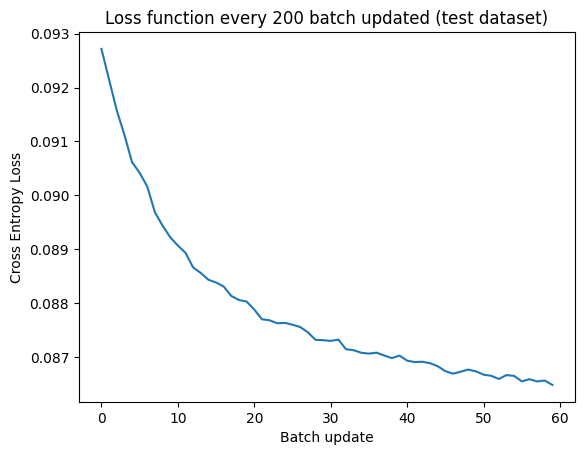

In [40]:
# Show the Loss function: I can understand if the model actually learned something
plt.plot(range(0,len(test_loss)), test_loss)
plt.xlabel('Batch update')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every 200 batch updated (test dataset)')
plt.show()

In [41]:
evaluate_model(model, dataloaders['test'], device=device)

Accuracy on validation set: 98.20%


With the regularization we can see pretty similar results. I think it is due to the fact that the net is pretty simple and we train it for just 15 epochs. It would be nicer to increase the number of weights to train and the number of epochs (so to "risk" more to overfit) and see the results.

## Boost the Net
The only "experiments" that I made are about the learning rate. I think that in general the Net is pretty performative. Maybe changing the number on neurons in the hidden layers can bring some benefits. I would rather try to implement a droput level (we switch of half of the neurons in the layer randomly and train just half of them).
</br>
Heuristically, dropping out some neurons is like training different neural networks and then average the effects of different networks.

In [42]:
class NewNet(nn.Module):

    def __init__(self):
        super(NewNet, self).__init__()

        self.flatten = nn.Flatten(1, -1)
        self.layer1 = nn.Linear(28*28, 500)
        self.layer2 = nn.Linear(500, 250)
        self.layer3 = nn.Linear(250, 100)
        self.output_layer = nn.Linear(100, 10)
        self.relu = nn.ReLU()

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Flatten the matrix
        x = self.flatten(x)
        # First layer
        out1 = self.relu(self.layer1(x))
        x = self.dropout(x)
        # Second layer
        out2 = self.relu(self.layer2(out1))
        x = self.dropout(x)
        # Third layer
        out3 = self.relu(self.layer3(out2))
        x = self.dropout(x)
        # Output layer: CrossEntropyLoss() already combines softmax and loss
        output = self.output_layer(out3)
        return output

In [43]:
modelnew = NewNet().to(device)
print(modelnew)

summary(modelnew,input_size=(1,28*28))

NewNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=250, bias=True)
  (layer3): Linear(in_features=250, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 784]               0
            Linear-5                  [-1, 250]         125,250
              ReLU-6                  [-1, 250]               0
           Dropout-7                  [-1, 784]               0
            Linear-8                  [-1,

In [44]:
# Initialize the model, criterion, and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelnew.parameters(), lr=learning_rate, weight_decay=1e-5) # I also add L2 reg to the loss function

# Train the model
train_loss, _, _, _ = train_model(modelnew, dataloaders['train'], criterion, optimizer, num_epochs=15, device=device)

Epoch [1/15], Loss: 0.2242
Epoch [2/15], Loss: 0.0906
Epoch [3/15], Loss: 0.0682
Epoch [4/15], Loss: 0.0515
Epoch [5/15], Loss: 0.0444
Epoch [6/15], Loss: 0.0361
Epoch [7/15], Loss: 0.0320
Epoch [8/15], Loss: 0.0279
Epoch [9/15], Loss: 0.0234
Epoch [10/15], Loss: 0.0253
Epoch [11/15], Loss: 0.0219
Epoch [12/15], Loss: 0.0190
Epoch [13/15], Loss: 0.0196
Epoch [14/15], Loss: 0.0170
Epoch [15/15], Loss: 0.0171


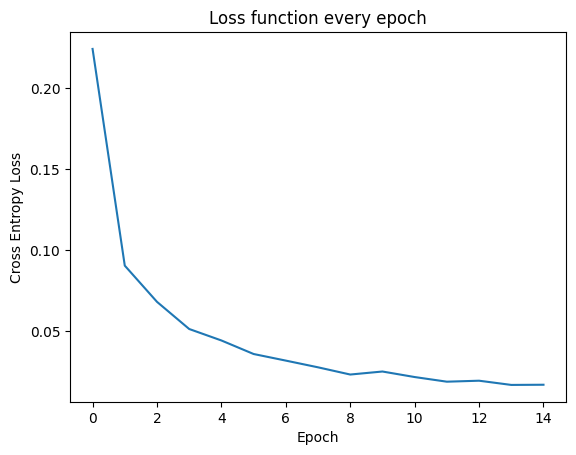

In [45]:
plt.plot(range(0,len(train_loss)), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss function every epoch')
plt.show()

In [46]:
evaluate_model(modelnew, dataloaders['test'], device=device)

Accuracy on validation set: 98.22%


Also the dropout technique seems to give nice results.

## References


*   Nielsen, M. A. (2015). Neural networks and deep learning. Determination Press.
*   Mnielsen. (n.d.). neural-networks-and-deep-learning/src at master · mnielsen/neural-networks-and-deep-learning. GitHub. https://github.com/mnielsen/neural-networks-and-deep-learning/tree/master/src
*   Bishop, C. M. (1994). Neural networks for pattern recognition.
*   Kämäräinen, J.-K. (2023). Pattern recognition and machine learning [DATA.ML.200]. Tampere University. (Personal notes).